In [2]:
import numpy as np
import pandas
import torch

from simulation_study_helpers import *
from training_helpers import *
from nf_mctm import *
import mlflow

In [2]:
#experiment_id = mlflow.create_experiment(name="test_sim_study",artifact_location="/Users/maherp/Desktop/Universitaet/Goettingen/5_Semester/master_thesis/mctm_pytorch/mlflow_storage/test_sim_study/")
experiment_id = 1

In [3]:
seed_value = 1
penvalueridge = 0
penfirstridge = 0
pensecondridge = 0
poly_span_abs = 15
spline_decorrelation = "bspline"
iterations = 400
learning_rate = 0.5
patience = 5
min_delta = 1e-7
degree_transformations=10
degree_decorrelation=12
normalisation_layer=None

In [4]:
mlflow.start_run(
    run_name="{}".format(seed_value),
    experiment_id=experiment_id,
    tags={"seed": seed_value}
)

<ActiveRun: >

In [5]:
mlflow.log_param(key="seed",value=seed_value)
mlflow.log_param(key="pen_value_ridge", value=penvalueridge)
mlflow.log_param(key="pen_first_ridge", value=penfirstridge)
mlflow.log_param(key="pen_second_ridge", value=pensecondridge)
mlflow.log_param(key="poly_span_abs", value=poly_span_abs)
mlflow.log_param(key="spline_decorrelation", value=spline_decorrelation)
mlflow.log_param(key="iterations", value=iterations)
mlflow.log_param(key="learning_rate", value=learning_rate)
mlflow.log_param(key="patience", value=patience)
mlflow.log_param(key="min_delta", value=min_delta)
mlflow.log_param(key="degree_transformations", value=degree_transformations)
mlflow.log_param(key="degree_decorrelation", value=degree_decorrelation)
mlflow.log_param(key="normalisation_layer", value=normalisation_layer)

In [6]:
set_seeds(seed_value)
y_train, train_likelihood = create_data(2000)
y_test, test_likelihood  = create_uniform_test_grid(num_observations=2000,ci_border=0.99)

 51%|█████▏    | 205/400 [00:54<00:52,  3.74it/s]

Early Stop!


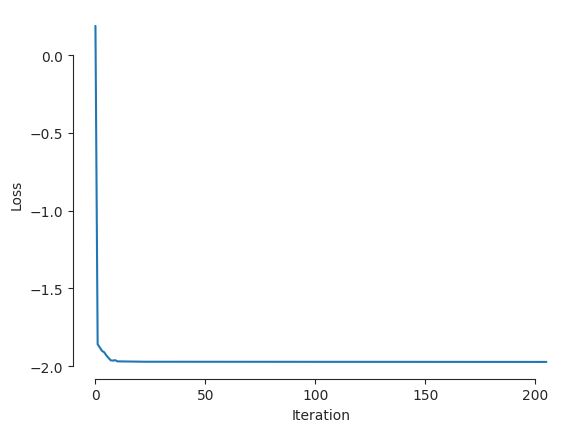

In [7]:
poly_range = torch.FloatTensor([[-poly_span_abs], [poly_span_abs]])
penalty_params = torch.tensor([penvalueridge,
                              penfirstridge,
                              pensecondridge])

nf_mctm = NF_MCTM(input_min=y_train.min(0).values,
                  input_max=y_train.max(0).values,
                  polynomial_range=poly_range,
                  number_variables=3,
                  spline_decorrelation=spline_decorrelation,
                  degree_transformations=degree_transformations,
                  degree_decorrelation=degree_decorrelation,
                  normalisation_layer=normalisation_layer)

#no epochs required
loss_training_iterations = train(model=nf_mctm,
                                               train_data=y_train,
                                               penalty_params=penalty_params,
                                               iterations=iterations,
                                               learning_rate=learning_rate,
                                               patience=patience,
                                               min_delta=min_delta,
                                               verbose=False)

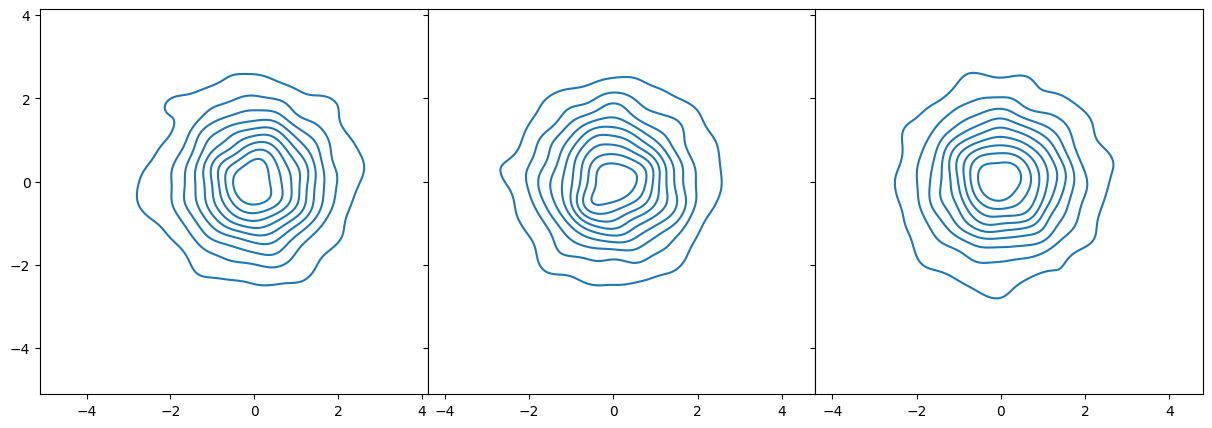

In [8]:
#### Training
# Evaluate latent space of the model in training set
z_train = nf_mctm.forward(y_train,train=False).detach().numpy()
res_normal_train, res_pval_train, z_mean_train, z_cov_train, p_train = evaluate_latent_space(z_train)
fig_train = plot_latent_space(z_train)

kl_divergence_nf_mctm_train = test_kl_divergence(model=nf_mctm,
                                                 test_data=y_train,
                                                 test_likelihood=train_likelihood)

#estimate true model on training data
est_mean = torch.mean(y_train,0)
est_cov = torch.cov(y_train.T)
y_distribution_est = MultivariateNormal(est_mean, est_cov)
train_likelihood_estimated_true_model = y_distribution_est.log_prob(y_test)
test_likelihood_estimated_true_model = y_distribution_est.log_prob(y_test)

kl_loss = nn.KLDivLoss(reduction="batchmean", log_target=True)
kl_divergence_true_model_train = kl_loss(train_likelihood, train_likelihood_estimated_true_model)

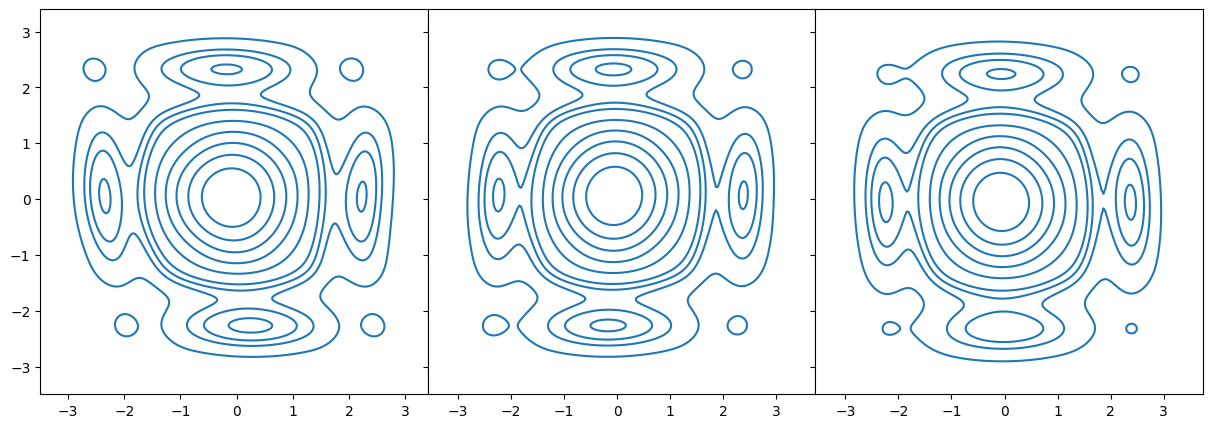

In [9]:
#### Test
# Evaluate latent space of the model in test set
z_test = nf_mctm.forward(y_test,train=False).detach().numpy()
res_normal_test, res_pval_test, z_mean_test, z_cov_test, p_test = evaluate_latent_space(z_test)
fig_test = plot_latent_space(z_test)

kl_divergence_nf_mctm_test = test_kl_divergence(model=nf_mctm,
                                   test_data=y_test,
                                   test_likelihood=test_likelihood)

kl_loss = nn.KLDivLoss(reduction="batchmean", log_target=True)
kl_divergence_true_model_test = kl_loss(test_likelihood, test_likelihood_estimated_true_model)

In [10]:
# Log Training Artifacts
model_info = mlflow.pytorch.log_model(nf_mctm, "nf_mctm_model")

np.save("loss_training_iterations.npy", loss_training_iterations)
mlflow.log_artifact("./loss_training_iterations.npy")

/opt/anaconda3/envs/mctm_pytorch_37/lib/python3.7/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [11]:
# Log Train Data Metrics and Artifacts
mlflow.log_metric("mv_normality_result_train",res_normal_train)
mlflow.log_metric("mv_normality_pval_train",res_pval_train)

np.save("z_mean_train.npy", z_mean_train)
mlflow.log_artifact("./z_mean_train.npy")

np.save("z_cov_train.npy", z_cov_train)
mlflow.log_artifact("./z_cov_train.npy")

np.save("uv_normality_pvals_train.npy", p_train)
mlflow.log_artifact("./uv_normality_pvals_train.npy")

fig_train.savefig('plot_latent_space_train.png')
mlflow.log_artifact("./plot_latent_space_train.png")

mlflow.log_metric("kl_divergence_nf_mctm_train",kl_divergence_nf_mctm_train)
mlflow.log_metric("kl_divergence_true_model_train",kl_divergence_true_model_train)

In [12]:
# Log Test Data Metrics and Artifacts
mlflow.log_metric("mv_normality_result_test",res_normal_test)
mlflow.log_metric("mv_normality_pval_train",res_pval_test)

np.save("z_mean_test.npy", z_mean_test)
mlflow.log_artifact("./z_mean_test.npy")

np.save("z_cov_test.npy", z_cov_test)
mlflow.log_artifact("./z_cov_test.npy")

np.save("uv_normality_pvals_test.npy", p_test)
mlflow.log_artifact("./uv_normality_pvals_test.npy")

fig_test.savefig('plot_latent_space_test.png')
mlflow.log_artifact("./plot_latent_space_test.png")

mlflow.log_metric("kl_divergence_nf_mctm_test",kl_divergence_nf_mctm_test)
mlflow.log_metric("kl_divergence_true_model_test",kl_divergence_true_model_test)

In [13]:
mlflow.end_run()

In [6]:
import pandas as pd
import torch
seed_value=1

In [10]:
int(seed_value)

1

In [19]:
torch.tensor(pd.read_csv("simulation_study_data/joe_3_2000/" + str(seed_value) + "_est_train_log_likelihoods.csv").values).flatten().size()

torch.Size([1999])

In [14]:
!mlflow ui

[2023-01-27 11:51:39 +0100] [8607] [INFO] Starting gunicorn 20.1.0
[2023-01-27 11:51:39 +0100] [8607] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-01-27 11:51:39 +0100] [8607] [ERROR] Retrying in 1 second.
[2023-01-27 11:51:40 +0100] [8607] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-01-27 11:51:40 +0100] [8607] [ERROR] Retrying in 1 second.
[2023-01-27 11:51:41 +0100] [8607] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-01-27 11:51:41 +0100] [8607] [ERROR] Retrying in 1 second.
[2023-01-27 11:51:42 +0100] [8607] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-01-27 11:51:42 +0100] [8607] [ERROR] Retrying in 1 second.
[2023-01-27 11:51:43 +0100] [8607] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-01-27 11:51:43 +0100] [8607] [ERROR] Retrying in 1 second.
[2023-01-27 11:51:44 +0100] [8607] [ERROR] Can't connect to ('127.0.0.1', 5000)
Running the mlflow server failed. Please see the logs above for details.


In [14]:
sns.scatterplot(x=z_train[0,:], y=z_train[1,:],alpha=0.6,color="k")
sns.kdeplot(x=z_train[0,:], y=z_train[1,:], fill=True, alpha=0.6, levels=5)
plt.show()

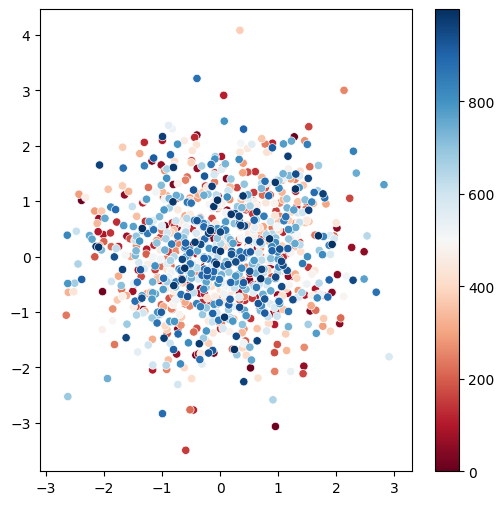

In [231]:
x_lim = (z_train[:,0].min(),z_train[:,0].max())
z_train = torch.distributions.Normal(0,1).sample((1000,2)).detach().numpy()
kl = np.array(range(1000))
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=z_train[:,0], y=z_train[:,1], hue=kl, ax = ax, palette='RdBu')
ax.set_xlim(x_lim)

norm = plt.Normalize(kl.min(), kl.max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)
#im = ax.imshow(kl, cmap='bone')
#divider = make_axes_locatable(ax)
#cax = divider.append_axes('right', size='5%', pad=0.05)
#fig.colorbar(im) #cax=cax, orientation='vertical')

In [44]:
import mlflow

In [56]:
experiment_data = mlflow.search_runs(experiment_ids=["1"])

In [68]:
experiment_data["start_time"][0]

Timestamp('2023-01-31 10:16:23.323000+0000', tz='UTC')

In [70]:
run_id = experiment_data["run_id"][0]
run_id

'be8d4cd97d8b4baea6724f040378d79d'

In [71]:
experiment_data["artifact_uri"][0]

'/Users/maherp/Desktop/Universitaet/Goettingen/5_Semester/master_thesis/mctm_pytorch/mlflow_storage/test_sim_study/be8d4cd97d8b4baea6724f040378d79d/artifacts'

In [65]:
run = mlflow.get_run(run_id)

In [66]:
run.data

<RunData: metrics={'kl_divergence_nf_mctm_test': 0.012759829871356487,
 'kl_divergence_nf_mctm_train': 0.01200618501752615,
 'kl_divergence_true_model_test': 0.00173027697019279,
 'kl_divergence_true_model_train': 0.0015236438484862447,
 'mv_normality_pval_train': 1.8622026664077878e-17,
 'mv_normality_result_test': 0.0,
 'mv_normality_result_train': 0.0,
 'number_iterations': 1.0,
 'training_time': 1.9436960220336914}, params={'degree_decorrelation': '10',
 'degree_transformations': '10',
 'iterations': '2',
 'learning_rate': '0.5',
 'min_delta': '1e-08',
 'normalisation_layer': 'None',
 'patience': '10',
 'pen_first_ridge': '0',
 'pen_second_ridge': '0',
 'pen_value_ridge': '0',
 'poly_span_abs': '5',
 'spline_decorrelation': 'bspline'}, tags={'copula': 'joe',
 'mlflow.log-model.history': '[{"run_id": "be8d4cd97d8b4baea6724f040378d79d", '
                             '"artifact_path": "nf_mctm_model", '
                             '"utc_time_created": "2023-01-31 '
                 

In [73]:
model = mlflow.pytorch.load_model("runs:/" + run_id + "/nf_mctm_model")

In [107]:
parameters = model.l1.params
parameters.size()

torch.Size([11, 3])

In [112]:
data_span = torch.linspace(-4,4,100)
data_span_vec = torch.vstack([data_span,data_span]).T
data_span_vec.size()

torch.Size([100, 2])

In [124]:
data_span.reshape((100,1))

torch.Size([100, 1])

In [130]:
data_span.reshape((100,1)).repeat(1,num_splines).size()

torch.Size([100, 3])

In [ ]:
data_span.repeat(num_splines)

In [96]:
pred = model.l1.forward(data_span_vec)

In [135]:
model.l1.polynomial_range[1,0]

tensor(5.)

In [176]:
from bspline_prediction import *

In [225]:
def plot_splines(layer):

    num_splines = layer.params.size()[1]
    #num_variables = layer.number_variables
    poly_min = layer.polynomial_range[0,0]
    poly_max = layer.polynomial_range[1,0]

    data_span = torch.linspace(poly_min,poly_max,100)
    data_span_vec = data_span.reshape((100,1)).repeat(1,num_splines)

    if layer.type == "transformation":
        output, log_d = layer.forward(data_span_vec, return_log_d=True)
        output_derivativ = torch.exp(log_d).detach().numpy()
    elif layer.type == "decorrelation":
        output = data_span_vec.clone()
        for spline_num in range(num_splines):
            output[:,spline_num] = bspline_prediction(layer.params[:, spline_num],
                               data_span_vec[:, spline_num],
                               degree=layer.degree,
                               polynomial_range=layer.polynomial_range[:, 0], #assume same polly range across variables
                               monotonically_increasing=False,
                               derivativ=0)

    data_span_vec = data_span_vec.detach().numpy()
    output = output.detach().numpy()

    if num_splines > 1 :
        fig, axs = plt.subplots(nrows=1, ncols=num_splines, figsize=(15,5),
                                gridspec_kw={'wspace':0.0, 'hspace':0.0},sharey=True)
        a=0
        for spline_num in range(num_splines):
            sns.lineplot(x=data_span_vec[:,spline_num], y=output[:,spline_num], ax = axs[a])
            if layer.type == "transformation":
                sns.lineplot(x=data_span_vec[:,spline_num], y=output_derivativ[:,spline_num], ax = axs[a])
            axs[a].set_ylim(output.min(), output.max())
            axs[a].set_xlim(poly_min, poly_max)
            a+=1

        plt.subplots_adjust(wspace=0.05)

    else:
        fig, ax = plt.subplots(figsize=(6, 6))
        sns.lineplot(x=data_span_vec.reshape(100), y=output.reshape(100), ax = ax)
        ax.set_ylim(output.min(), output.max())
        ax.set_xlim(poly_min, poly_max)


    return fig

In [204]:
np.arange(6).reshape((6,1)).reshape(6).shape

(6,)

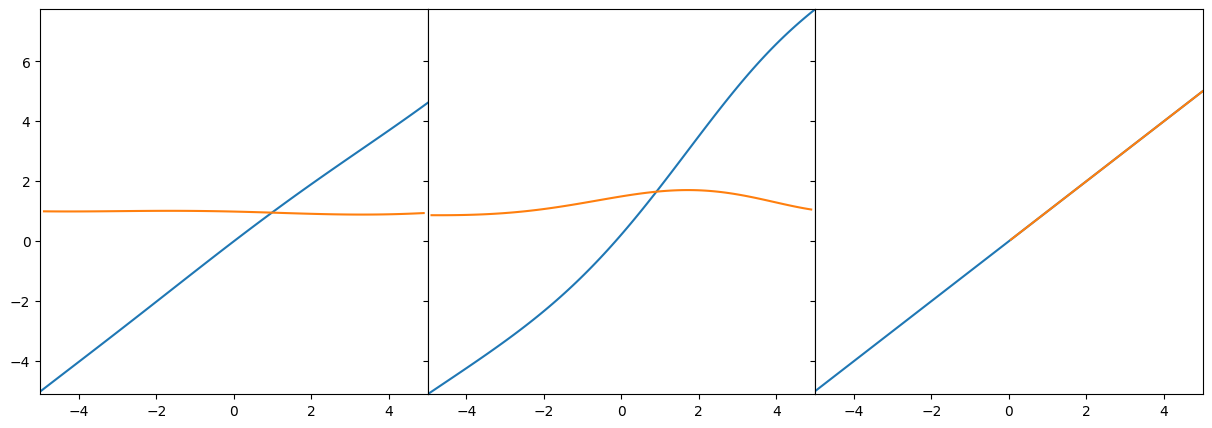

In [226]:
model.l1.type = "transformation"
fig = plot_splines(model.l1)

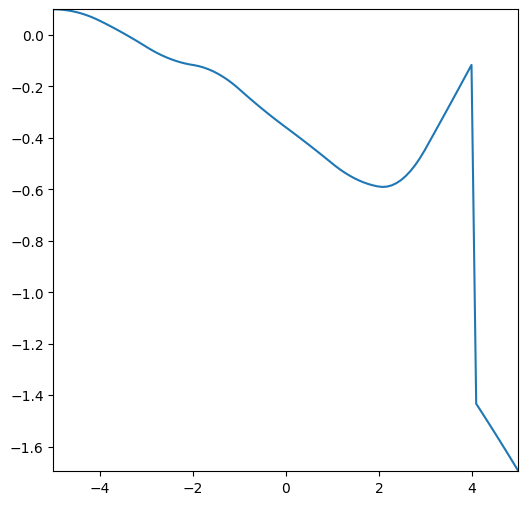

In [208]:
model.l2.type = "decorrelation"
fig = plot_splines(model.l2)

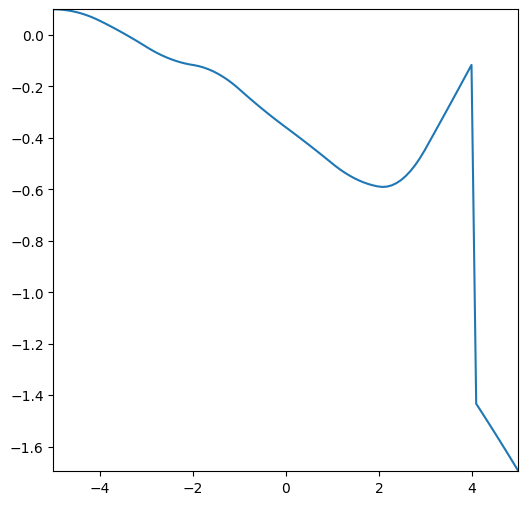

In [210]:
model.l4.type = "decorrelation"
fig = plot_splines(model.l4)

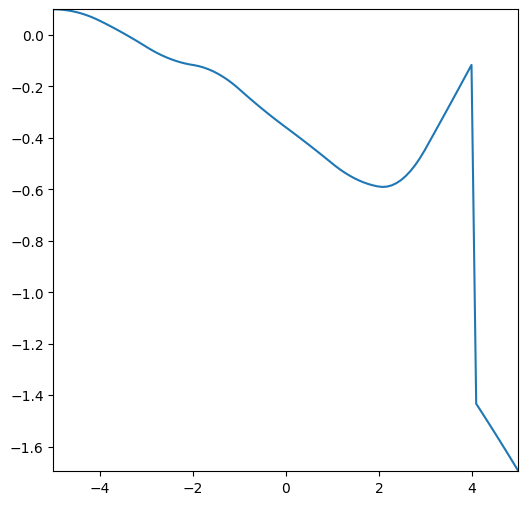

In [211]:
model.l6.type = "decorrelation"
fig = plot_splines(model.l6)

In [222]:
torch.allclose(model.l2.params,model.l4.params,0.01) and torch.allclose(model.l2.params,model.l6.params,0.01)

True

In [221]:
torch.allclose(model.l2.params,model.l4.params,0.01)

True

In [209]:
model.l2.params

Parameter containing:
tensor([[ 0.1000],
        [ 0.0997],
        [ 0.0100],
        [-0.1029],
        [-0.1304],
        [-0.2923],
        [-0.4262],
        [-0.5741],
        [-0.6046],
        [-0.2807],
        [ 0.0547]], requires_grad=True)

In [142]:
model.l2.params.size()

torch.Size([11, 1])

<AxesSubplot:>

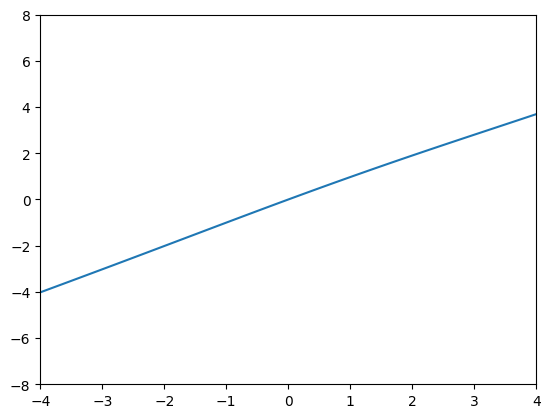

In [105]:
ax = sns.lineplot(y=pred[:,0].detach().numpy(), x=data_span.detach().numpy(), )
ax.set_ylim(-8, 8)
ax.set_xlim(-4, 4)
ax

<AxesSubplot:>

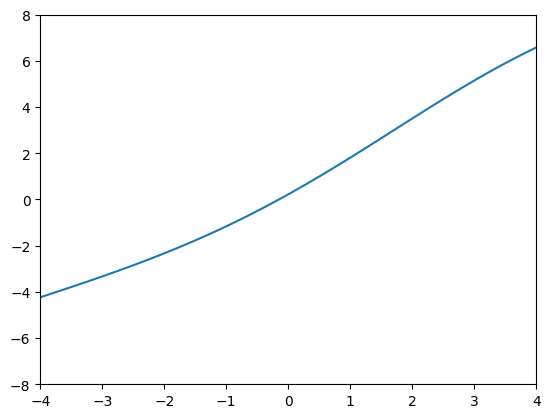

In [104]:
ax = sns.lineplot(y=pred[:,1].detach().numpy(), x=data_span.detach().numpy(), )
ax.set_ylim(-8, 8)
ax.set_xlim(-4, 4)
ax

In [257]:
import itertools
from sklearn.model_selection import KFold

In [253]:
[0,1,10,20,50]

[1.0,
 2.718281828459045,
 7.38905609893065,
 20.085536923187668,
 54.598150033144236]

In [ ]:
penvalueridge_list  = [0,1,10,20,50]
penfirstridge_list  = [0,1,10,20,50]
pensecondridge_list  = [0,1,10,20,50]
learning_rate_list  = [0,1,10,20,50]
patience_list = [0,1,10,20,50]
min_delta_list  =
degree_transformations_list =
degree_decorrelation_list =
normalisation_layer_list =
                             =

In [ ]:
list_of_lists = [penvalueridge_list,penfirstridge_list,pensecondridge_list,
                 learning_rate_list,
                 patience_list,min_delta_list,
                 degree_transformations_list,degree_decorrelation_list,
                 normalisation_layer_list]
hyperparameter_combinations_list = list(itertools.product(*list_of_lists))

In [270]:
list_of_lists = [np.exp(range(0,5)),np.exp(range(0,5))]
hyperparameter_combinations_list = list(itertools.product(*list_of_lists))

splits = KFold(n_splits=1)

for hyperparamters in hyperparameter_combinations_list:
    a, b = hyperparamters

    for train_idx, val_idx in splits.split(torch.tensor([10,20,30,40,50])):
        train_idx
        val_idx

IndentationError: expected an indented block (465457603.py, line 10)

In [276]:
splits = KFold(n_splits=5)

In [280]:
pd.DataFrame("loss"=[0,0],"par"=[1,2])
pd.DataFrame(data, columns=['Name', 'Age'])

SyntaxError: keyword can't be an expression (2947158371.py, line 1)

In [286]:
n_obs = 10
for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(n_obs))):
    print(fold)
    print(train_idx)
    print(val_idx)

0
[2 3 4 5 6 7 8 9]
[0 1]
1
[0 1 4 5 6 7 8 9]
[2 3]
2
[0 1 2 3 6 7 8 9]
[4 5]
3
[0 1 2 3 4 5 8 9]
[6 7]
4
[0 1 2 3 4 5 6 7]
[8 9]


In [297]:
technologies = {
    'Courses':["Spark","PySpark","Spark","PySpark","Spark"],
    'fold' :[1,2,1,2,1],
    'Duration':['30days','40days','30days','40days','30days'],
    'Discount':[1000,2300,1200,2000,12] }

In [303]:
df = pd.DataFrame(technologies)

In [318]:
df2 = df.groupby(['Courses','Duration']).mean()

In [324]:
df2[df2.Discount == df2.Discount.max()]

,,fold,Discount
Courses,Duration,,
PySpark,40days,2.0,2150.0


In [327]:
a,b = np.array([1,2])

In [334]:
import torch
from torch import nn

class Flip(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        return torch.flip(x, [1])

flipper = Flip()
x = torch.tensor([[1,2,3,4,5],[-1,-2,-3,-4,-5]]).T
print(x.size())
print(x)
print(flipper(x))

torch.Size([5, 2])
tensor([[ 1, -1],
        [ 2, -2],
        [ 3, -3],
        [ 4, -4],
        [ 5, -5]])
tensor([[-1,  1],
        [-2,  2],
        [-3,  3],
        [-4,  4],
        [-5,  5]])
